In [1]:
!pip install category_encoders feature_engine kaleido scikit-learn-intelex shap > /dev/null

In [57]:
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import category_encoders as ce

# from feature_engine.imputation import RandomSampleImputer

# sklearn imports
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import estimator_html_repr
from sklearn_pandas import DataFrameMapper
from sklearnex import patch_sklearn
patch_sklearn()

# plotly imports
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot

# warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

# Plotly rendering (work around Plotly rendering issues with GitHub)
pio.renderers.default = "svg"
# Plotly rendering for Google Coab
# pio.renderers.default = "colab"

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [58]:
df = pd.read_csv('data/Airline_customer_satisfaction.csv')

In [59]:
%%html
<style>
table {align:left;display:block}
</style>

|Column name	                  | Description                                                                |
|:------------------------------- |:-------------------------------------------------------------------------- |   
|Satisfaction	                  |Indicates the satisfaction level of the customer.                           |
|Customer Type	                  |Type of customer: 'Loyal Customer' or 'Disloyal Customer’.                  |
|Age	                          |Age of the customer.                                                        |
|Type of Travel	                  |Purpose of the travel: 'Business travel' or 'Personal Travel’.              |
|Class	                          |Class of travel: 'Business', 'Eco', or 'Eco Plus’.                          |
|Flight Distance	              |The distance of the flight in kilometres                                    |
|Seat comfort	                  |Rating of seat comfort provided during the flight (0:Not Applicable;1-5).   |
|Departure/Arrival time convenient|	Rating of the convenience of departure/arrival time (0:Not Applicable;1-5).|
|Food and drink	Rating            |of food and drink quality provided during the flight (0:Not Applicable;1-5).|
|Gate location	Rating            |of gate location convenience (0:Not Applicable;1-5).                        |
|Inflight wifi service            |Rating of inflight wifi service satisfaction (0:Not Applicable;1-5).        |
|Inflight entertainment           |Rating of inflight entertainment satisfaction (0:Not Applicable;1-5).       |
|Online support	                  |Rating of online customer support satisfaction (0:Not Applicable;1-5).      |
|Ease of Online booking	          |Rating of ease of online booking satisfaction ((0:Not Applicable;1-5).      |
|On-board service	              |Rating of on-board service satisfaction (0:Not Applicable;1-5).             |
|Leg room service	              |Rating of leg room service satisfaction (0:Not Applicable;1-5).             |
|Baggage handling	              |Rating of baggage handling satisfaction (0:Not Applicable;1-5).             |
|Checkin service	              |Rating of check-in service satisfaction (0:Not Applicable;1-5).             |
|Cleanliness	                  |Rating of cleanliness satisfaction (0:Not Applicable;1-5).                  |
|Online boarding	              |Rating of online boarding satisfaction (0:Not Applicable;1-5).              |
|Departure Delay in Minutes       |Total departure delay in minutes.                                           |
|Arrival Delay in Minutes	      |Total arrival delay in minutes.                                             |

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  object 
 1   Customer Type                      129880 non-null  object 
 2   Age                                129880 non-null  int64  
 3   Type of Travel                     129880 non-null  object 
 4   Class                              129880 non-null  object 
 5   Flight Distance                    129880 non-null  int64  
 6   Seat comfort                       129880 non-null  int64  
 7   Departure/Arrival time convenient  129880 non-null  int64  
 8   Food and drink                     129880 non-null  int64  
 9   Gate location                      129880 non-null  int64  
 10  Inflight wifi service              129880 non-null  int64  
 11  Inflight entertainment             1298

We can notice that there are some missing values for `Arrival Delay in Minutes`,  we wil impute them later.

In [61]:
df.head(5)

satisfaction   Customer Type  Age   Type of Travel     Class  \
0    satisfied  Loyal Customer   65  Personal Travel       Eco   
1    satisfied  Loyal Customer   47  Personal Travel  Business   
2    satisfied  Loyal Customer   15  Personal Travel       Eco   
3    satisfied  Loyal Customer   60  Personal Travel       Eco   
4    satisfied  Loyal Customer   70  Personal Travel       Eco   

   Flight Distance  Seat comfort  Departure/Arrival time convenient  \
0              265             0                                  0   
1             2464             0                                  0   
2             2138             0                                  0   
3              623             0                                  0   
4              354             0                                  0   

   Food and drink  Gate location  ...  Online support  Ease of Online booking  \
0               0              2  ...               2                       3   
1               0              3  ...               2                       3   
2               0              3  ...               2                       2   
3               0              3  ...               3                       1   
4               0              3  ...               4                       2   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0                 3                 0                 3                5   
1                 4                 4                 4                2   
2                 3                 3                 4                4   
3                 1                 0                 1                4   
4                 2                 0                 2                4   

   Cleanliness  Online boarding  Departure Delay in Minutes  \
0            3                2                           0   
1            3                2                         310   
2            4                2                           0   
3            1                3                           0   
4            2                5                           0   

   Arrival Delay in Minutes  
0                       0.0  
1                     305.0  
2                       0.0  
3                       0.0  
4                       0.0  

[5 rows x 22 columns]

### Data Cleanup

#### Cleaning Nulls

In [62]:
# Finding which columns have null values
null_counts = df.isnull().sum()
null_counts[null_counts > 0]

Arrival Delay in Minutes    393
dtype: int64

In [63]:
# Filter columns with null values
columns_with_nulls = null_counts[null_counts > 0].index.tolist()

# Initialize SimpleImputer
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on columns with null values
df[columns_with_nulls] = imputer.fit_transform(df[columns_with_nulls])

In [64]:

# Check if there're any null values left
null_counts = df.isnull().sum()
columns_with_nulls = null_counts[null_counts > 0]
print(f'Count of columns will null values: {len(columns_with_nulls)}')

Count of columns will null values: 0


In [65]:
print('Duplicates:', df.duplicated().sum())

Duplicates: 0


## Understanding the Features

#### Target feature distribution
Lets have a look at the distribution of `satisfaction` - the target classification feature

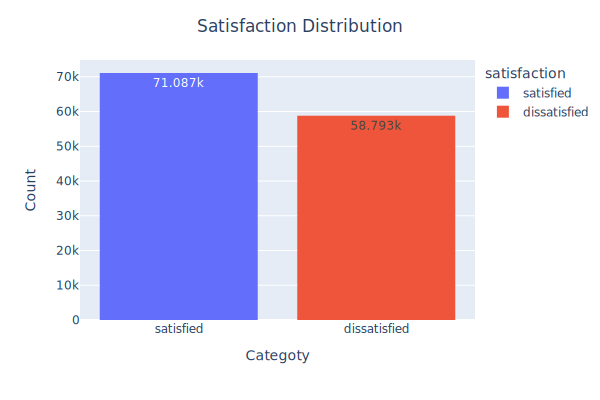

In [66]:
fig = px.histogram(df, x='satisfaction', color='satisfaction', text_auto=True)
fig.update_layout(title='Satisfaction Distribution',
                  title_x=0.5, title_y=0.95,
                  width=600, height=400,
                  yaxis_title='Count',
                  xaxis_title='Categoty')
fig.show()

In [67]:
satisfied =  len(df[df["satisfaction"] == "satisfied"]) / len(df)
dissatisfied = len(df[df["satisfaction"] == "dissatisfied"]) / len(df)
print(f'Satisfaction Distribution:')
print(f'sastisfied:   {satisfied*100:.3f}%')
print(f'dissatisfied: {dissatisfied*100:.3f}%')

Satisfaction Distribution:
sastisfied:   54.733%
dissatisfied: 45.267%


We can see that the target feature `satisfaction` is quite balanced, so there is no need to perform operations to balance it

#### Numerical Features

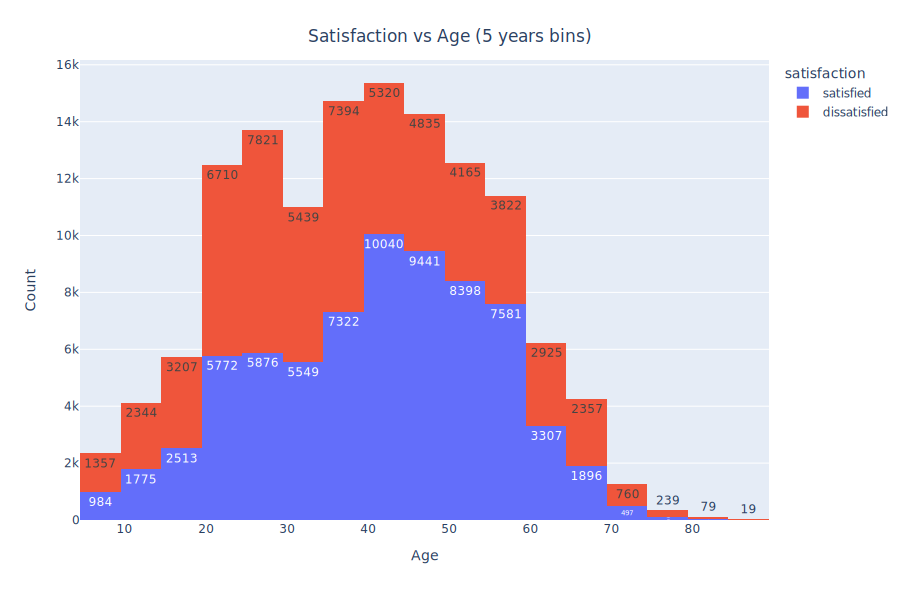

In [68]:
fig = px.histogram(df, x='Age', color='satisfaction', nbins=20, text_auto='.0f')
fig.update_layout(title='Satisfaction vs Age (5 years bins)',
                  title_x=0.5, title_y=0.95,
                  height=600, width=900,
                  yaxis_title='Count',
                  xaxis_title='Age').show()

We can see that satisfaction is higher when Age > 45. Customers younger than 40 showed less satisfaction.

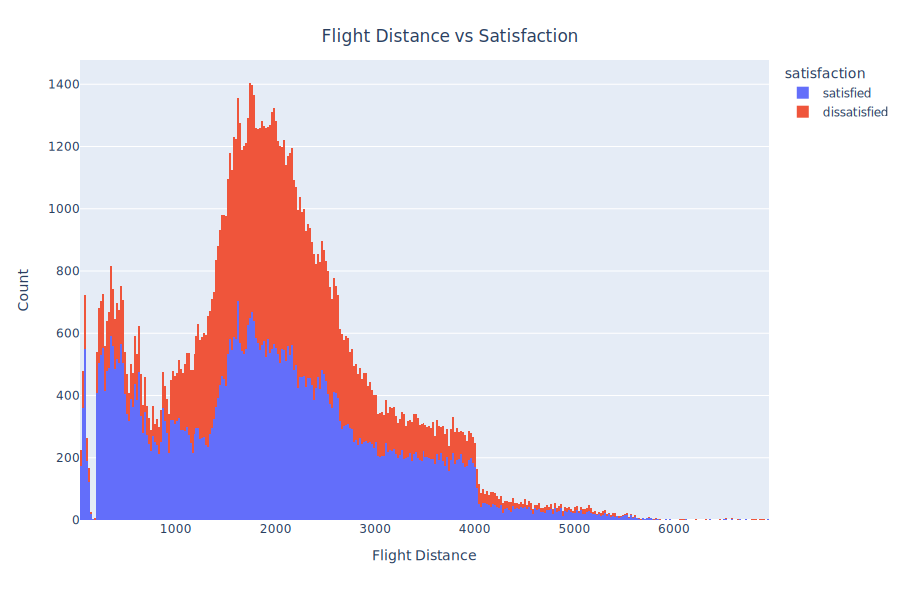

In [69]:
fig = px.histogram(df, x='Flight Distance', color='satisfaction')
fig.update_layout(title='Flight Distance vs Satisfaction',
                  title_x=0.5, title_y=0.95,
                  height=600, width=900,
                  yaxis_title='Count').show()


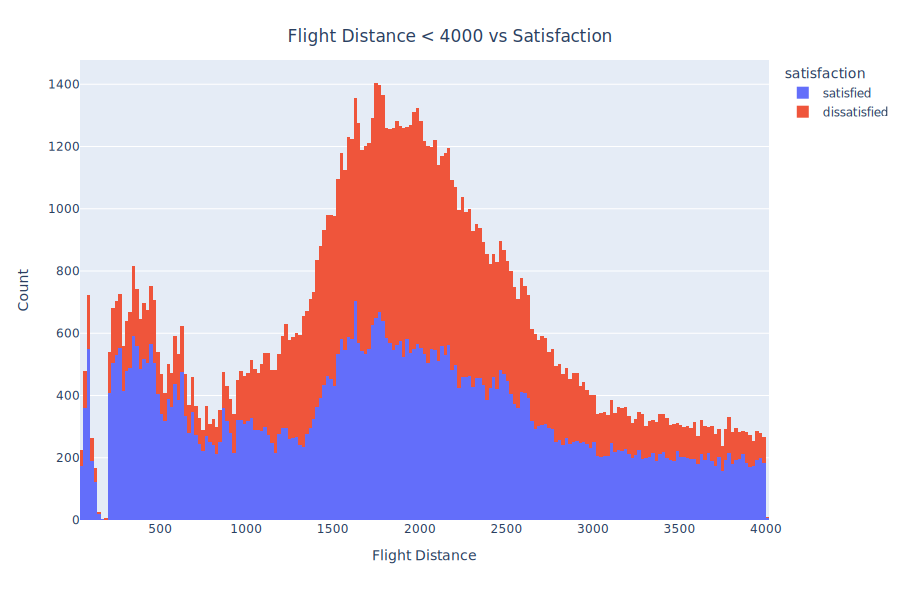

In [70]:
# Lets focus on the area in the graph that contains most of the data 0-4000 miles
fig = px.histogram(df[df['Flight Distance']<=4000], x='Flight Distance', color='satisfaction')
fig.update_layout(title='Flight Distance < 4000 vs Satisfaction',
                  title_x=0.5, title_y=0.95,
                  height=600, width=900,
                  yaxis_title='Count').show()

Air passengers eho fly mid-range flights (1000-3000 miles) showed more disatisfaction, compared to short flights asatisfaction and the overall satisfaction rate (55%)

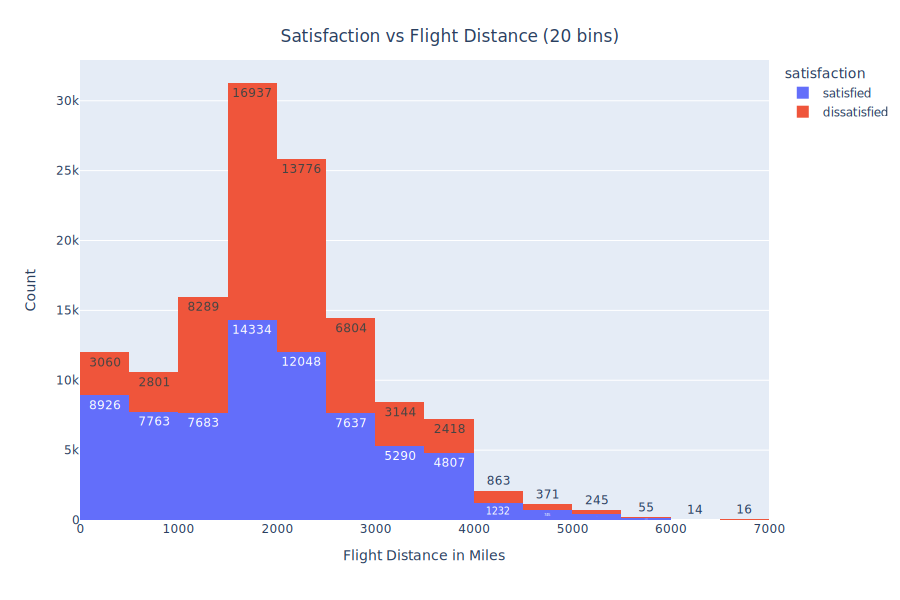

In [71]:
fig = px.histogram(df[(df['Flight Distance']<=10000)], x='Flight Distance', color='satisfaction', nbins=20, text_auto='.0f')
fig.update_layout(title='Satisfaction vs Flight Distance (20 bins)',
                  height=600, width=900,
                  title_x=0.5, title_y=0.95,
                  yaxis_title='Count',
                  xaxis_title='Flight Distance in Miles')
fig.show()

In [72]:
# Get a list of customer survey columns
survey_columns = df.iloc[:, 6:20].columns.tolist()
print(survey_columns)

['Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']


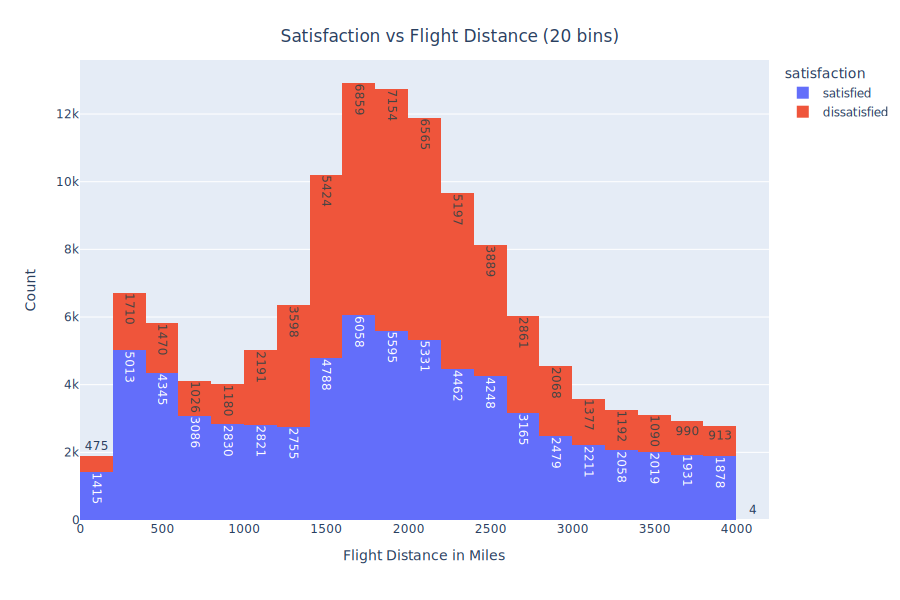

In [73]:
fig = px.histogram(df[(df['Flight Distance']<=4000)], x='Flight Distance', color='satisfaction', nbins=20, text_auto='.0f')
fig.update_layout(title='Satisfaction vs Flight Distance (20 bins)',
                  height=600, width=900,
                  title_x=0.5, title_y=0.95,
                  yaxis_title='Count',
                  xaxis_title='Flight Distance in Miles')
fig.show()

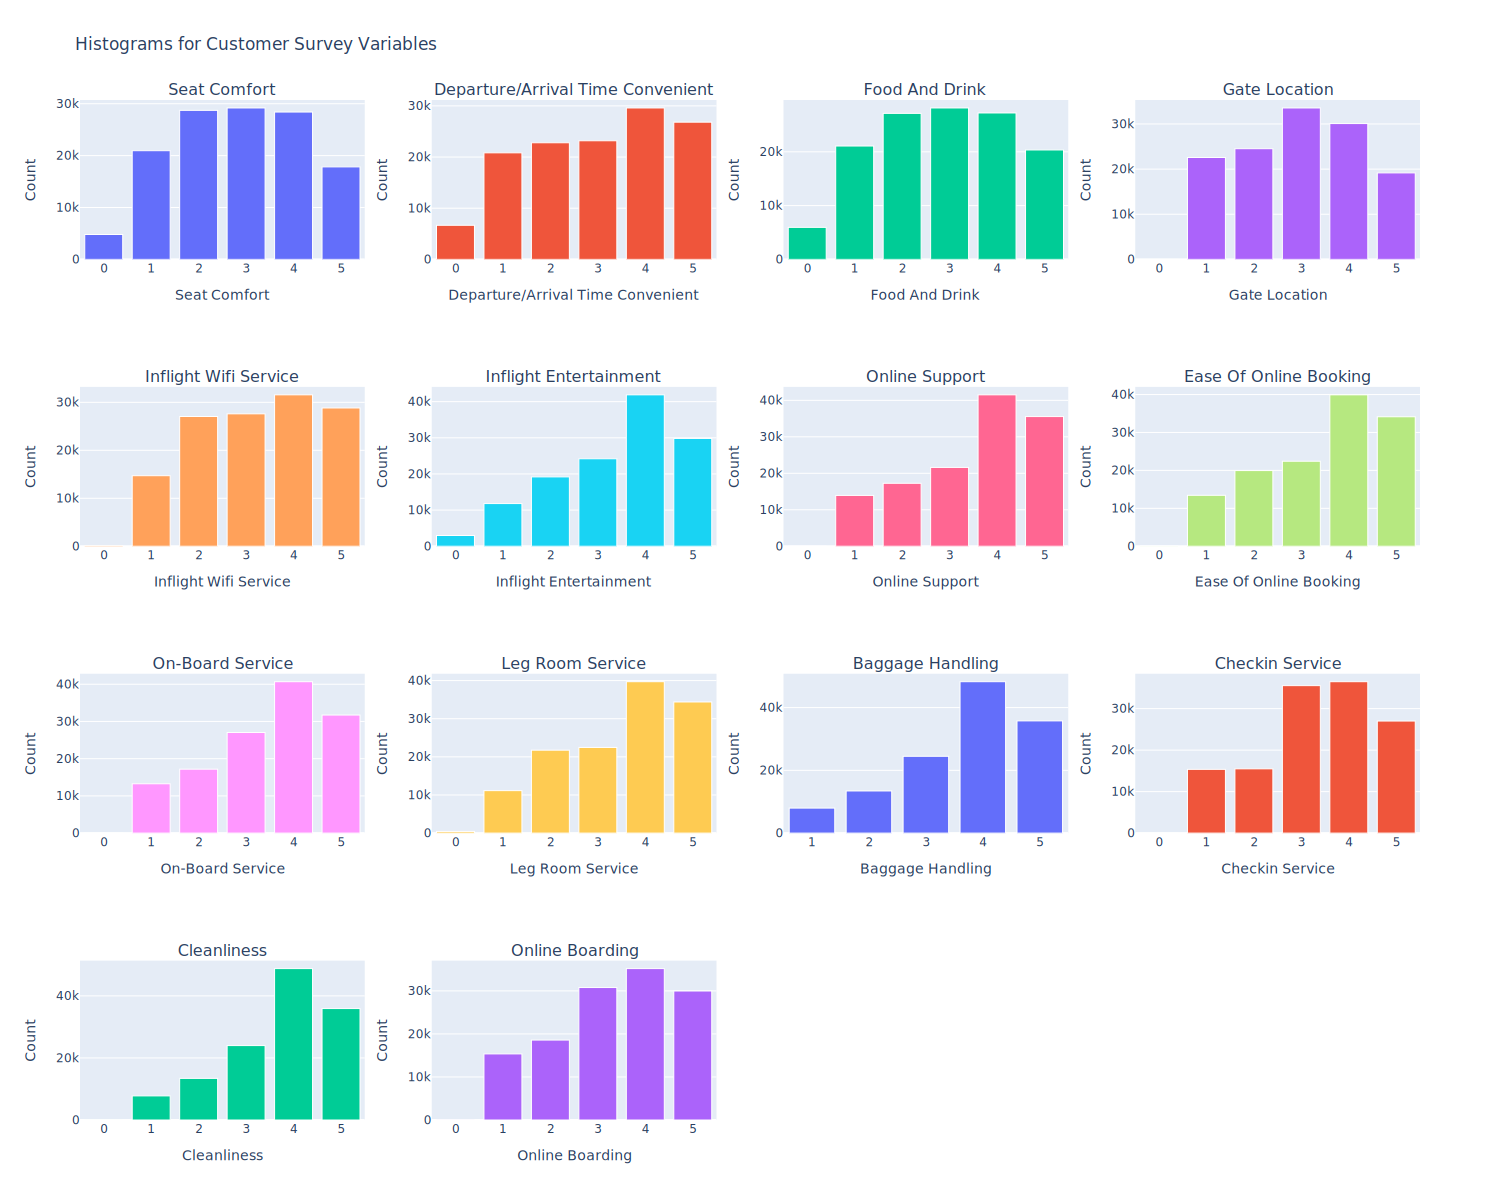

In [74]:
columns = survey_columns

dimension = math.ceil(np.sqrt(len(columns)))
fig = make_subplots(cols = dimension, rows = dimension, subplot_titles=(list(map(lambda x: x.replace('_', " ").title(), columns))))

for i, column in enumerate(columns):
    row = math.floor((i + dimension) / dimension)
    col = ((i + dimension) % dimension) + 1
    fig.add_histogram(x = df[column], row = row, col = col, showlegend=False)

    fig['layout'][f'xaxis{i+1}']['title'] = column.replace('_', " ").title()
    fig['layout'][f'yaxis{i+1}']['title'] = 'Count'

    fig.update_traces(marker_line_width=1,marker_line_color="white")
    if column in survey_columns:
      fig.update_xaxes(categoryorder='array', categoryarray= [0, 1, 2, 3, 4, 5])

fig.update_layout(height=1200, width=1500, title_text="Histograms for Customer Survey Variables")
fig.update_xaxes(type='category')
fig.show()

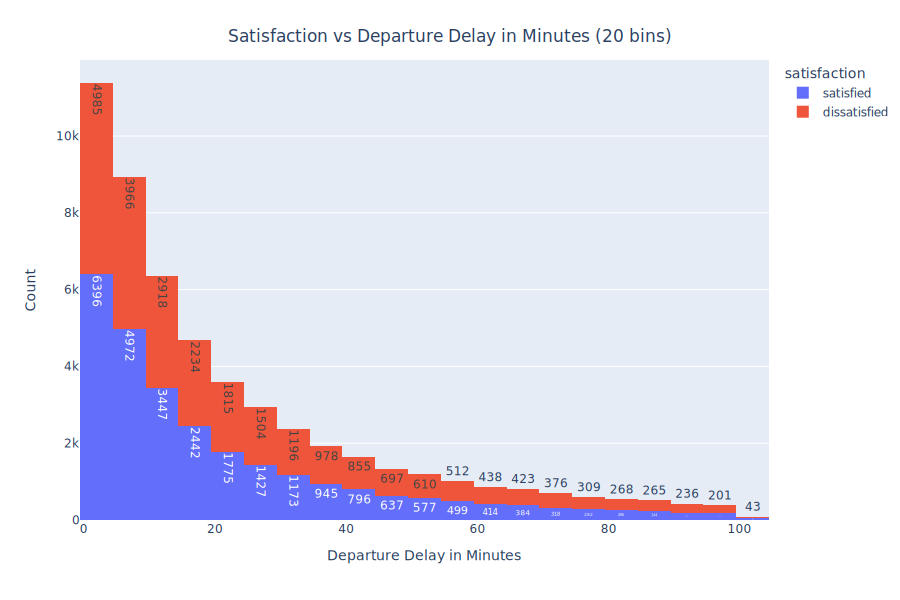

In [75]:
fig = px.histogram(df[(df['Departure Delay in Minutes']<=100) & (df['Departure Delay in Minutes']>0)], x='Departure Delay in Minutes', color='satisfaction', nbins=20, text_auto='.0f')
fig.update_layout(title='Satisfaction vs Departure Delay in Minutes (20 bins)',
                  height=600, width=900,
                  title_x=0.5, title_y=0.95,
                  yaxis_title='Count',
                  xaxis_title='Departure Delay in Minutes')
fig.show()

Departure delays of more than 20 minutes led to higher dissatisfaction precentage, compared to short delays

In [76]:
# We'll look at the distribution of Arrival and Departure Delays
columns =  ['Arrival Delay in Minutes', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Departure Delay in Minutes']
titles =  ['Arrival Delay in Minutes Histogram', 'Departure Delay in Minutes Histogram', 'Arrival Delay in Minutes BoxPlot', 'Departure Delay in Minutes BoxPlot']
dimensions = 2
fig = make_subplots(cols = 2, rows = 2, subplot_titles=titles)

dimension = 2

for i, column in enumerate(columns):
    row = math.floor((i + dimension) / dimensions)
    col = ((i + dimension) % dimension) + 1
    df_temp = df[df[column] > 0]
    if (row == 1) :
      fig.add_histogram(x = df_temp[column], row = row, col = col, showlegend=False)
      fig['layout'][f'yaxis{i+1}']['title'] = 'Count'
    else:
      fig.add_box(x = df_temp[column], row = row, col = col, showlegend=False)
      fig['layout'][f'yaxis{i+1}']['title'] = None

    fig['layout'][f'xaxis{i+1}']['title'] = 'Minutes'
    fig['layout'][f'yaxis{i+1}']['title']['standoff'] = 0
    fig['layout'][f'xaxis{i+1}']['title']['standoff'] = 0


fig.update_layout(height=600, width=900, title_text="Arrival and Departure Delay in Minutes Histograms and BoxPlots",  title_x=0.5, title_y=0.95)
fig.show()

Seems like we have some outliers at `Arrival Delay in Minutes` and `Departure Delay in Minutes` - lets remove them

In [77]:
# We'll remove the outliers for `Departure Delay in Minutes` and `Arrival Delay in Minutes`
from scipy.stats import zscore
features_with_outliers = ['Departure Delay in Minutes', 'Arrival Delay in Minutes']
outliers_list = []

for f in features_with_outliers:
    z_score = zscore(df[f])

    # removing outlier that are more than 3 standard deviations away from the mean
    threshold = 3

    outliers = df[abs(z_score) > threshold]
    outliers_list.extend(outliers.index)
    print(f'Number of outliers found for feature {f}: {len(outliers)}')

# dropping outliers
df_len_before = len(df)
print(f'df size before removing outliers: {df_len_before}')
df = df.drop(index=outliers_list).reset_index(drop=True)
print(f'df size after removing outliers: {len(df)}.\nTotal number of records removed: {df_len_before - len(df)} ')

Number of outliers found for feature Departure Delay in Minutes: 2748
Number of outliers found for feature Arrival Delay in Minutes: 2742
df size before removing outliers: 129880
df size after removing outliers: 126807.
Total number of records removed: 3073 


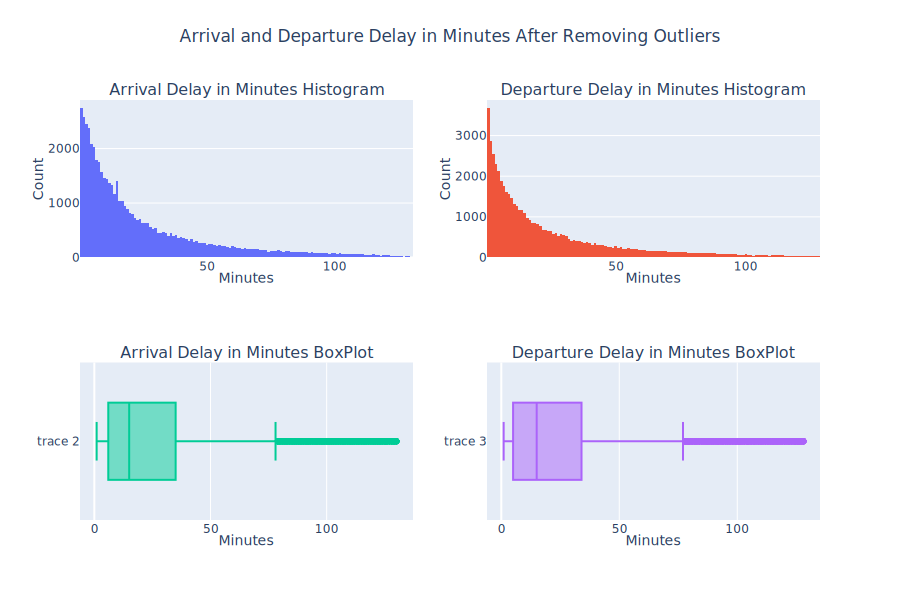

In [78]:
# We'll present the distribution of the 2 features after removing the outliers
columns =  ['Arrival Delay in Minutes', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Departure Delay in Minutes']
titles =  ['Arrival Delay in Minutes Histogram', 'Departure Delay in Minutes Histogram', 'Arrival Delay in Minutes BoxPlot', 'Departure Delay in Minutes BoxPlot']
dimensions = 2
fig = make_subplots(cols = 2, rows = 2, subplot_titles=titles)

dimension = 2

for i, column in enumerate(columns):
    row = math.floor((i + dimension) / dimensions)
    col = ((i + dimension) % dimension) + 1
    df_temp = df[df[column] > 0]
    if (row == 1) :
      fig.add_histogram(x = df_temp[column], row = row, col = col, showlegend=False)
      fig['layout'][f'yaxis{i+1}']['title'] = 'Count'
    else:
      fig.add_box(x = df_temp[column], row = row, col = col, showlegend=False)
      fig['layout'][f'yaxis{i+1}']['title'] = ''

    fig['layout'][f'xaxis{i+1}']['title'] = 'Minutes'
    fig['layout'][f'yaxis{i+1}']['title']['standoff'] = 0
    fig['layout'][f'xaxis{i+1}']['title']['standoff'] = 0


fig.update_layout(height=600, width=900, title_text="Arrival and Departure Delay in Minutes After Removing Outliers",  title_x=0.5, title_y=0.95)
fig.show()


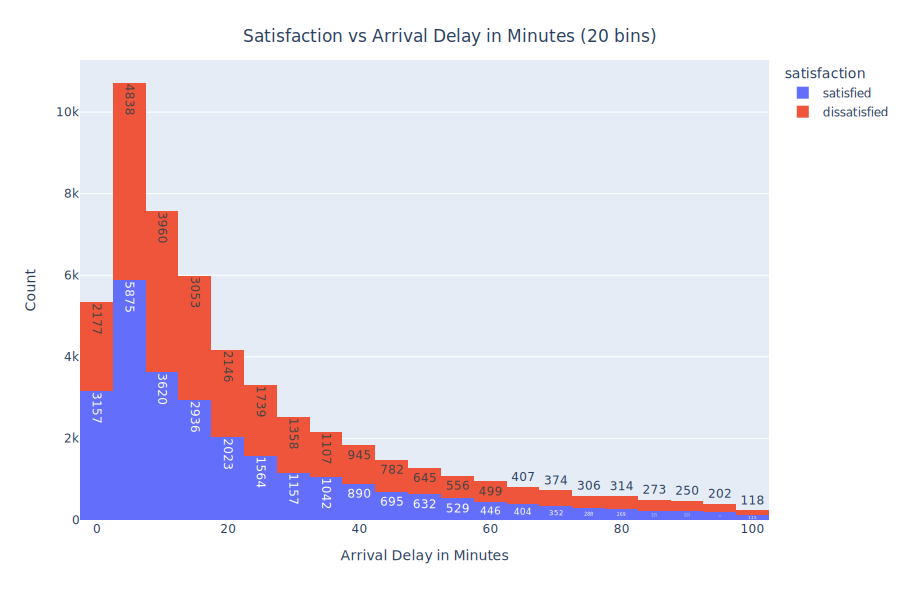

In [79]:
fig = px.histogram(df[(df['Arrival Delay in Minutes']<=100) & (df['Arrival Delay in Minutes']>0)], x='Arrival Delay in Minutes', color='satisfaction', nbins=20, text_auto='.0f')
fig.update_layout(title='Satisfaction vs Arrival Delay in Minutes (20 bins)',
                  height=600, width=900,
                  title_x=0.5, title_y=0.95,
                  yaxis_title='Count',
                  xaxis_title='Arrival Delay in Minutes')
fig.show()

#### Categorical features and Customer Survey features

We will now analyze categorical and customer survey features: 
 ['Customer Type', 'Type of Travel', 'Class', 'Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']


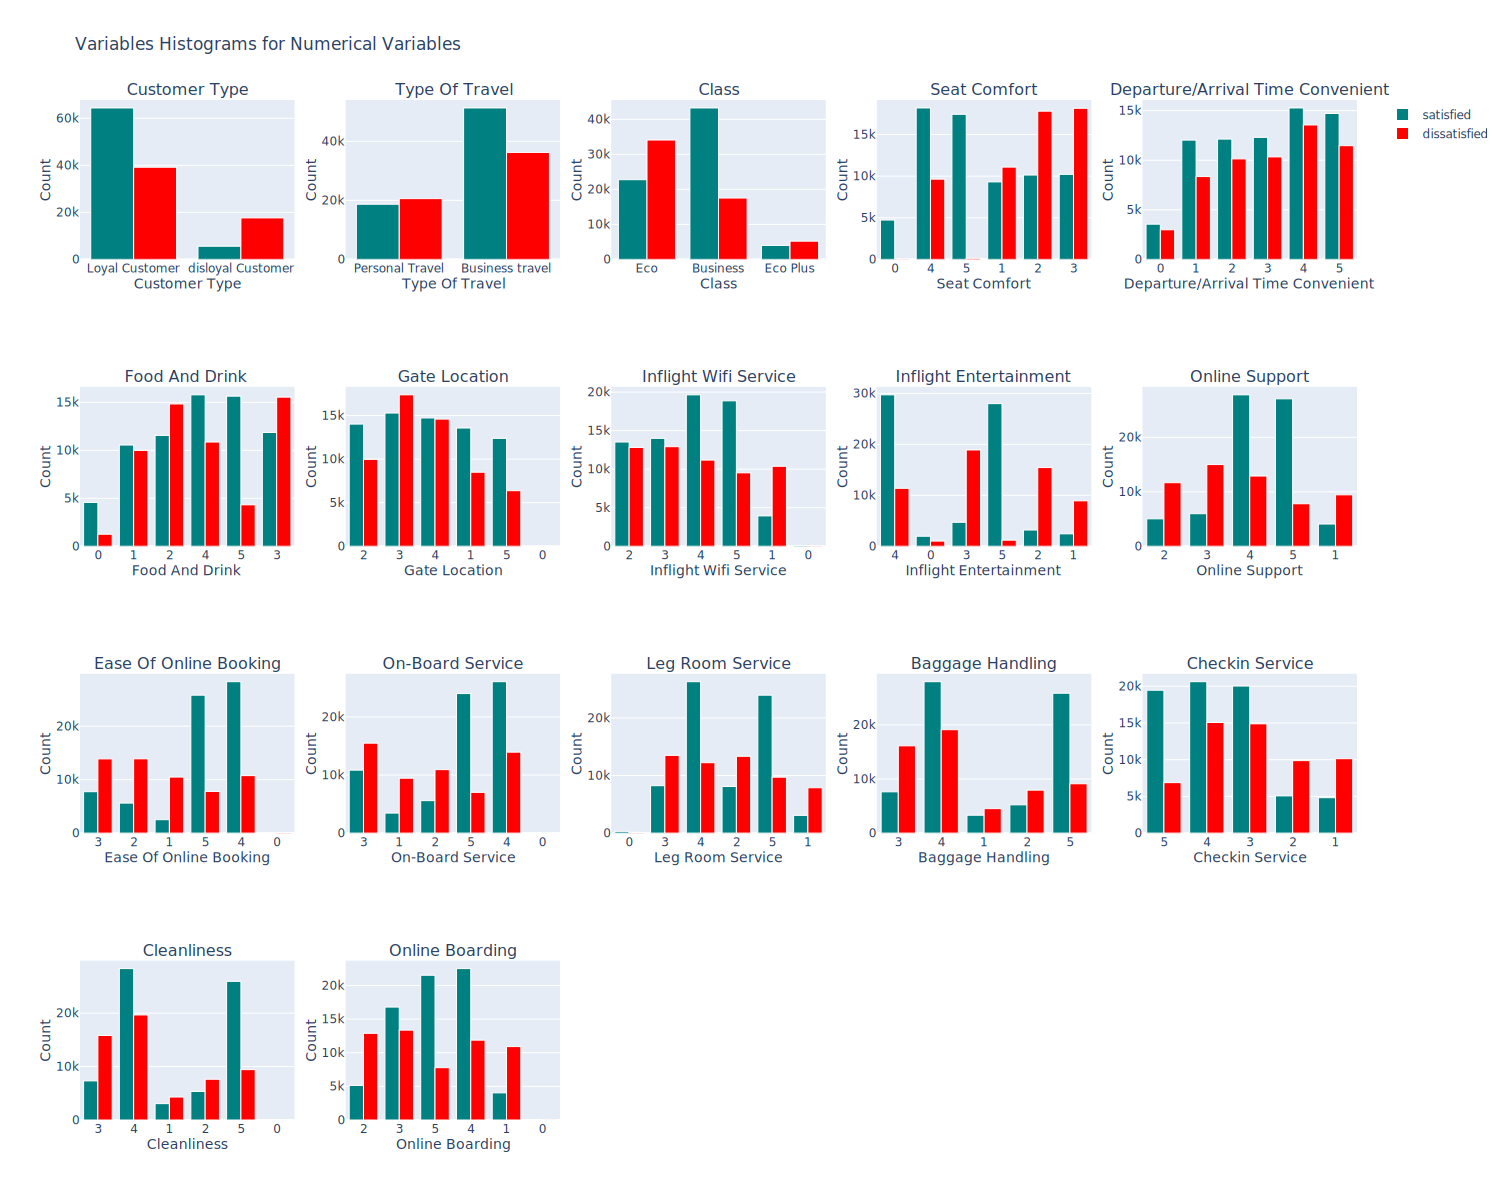

In [80]:
columns = df.columns.tolist()
# removing numerical features that are not customer survey features
for x in ['Age','Flight Distance','Arrival Delay in Minutes', 'Departure Delay in Minutes', 'satisfaction']:
    columns.remove(x)

print(f'We will now analyze categorical and customer survey features: \n {columns}')
dimension = math.ceil(np.sqrt(len(columns)))
fig = make_subplots(cols = dimension, rows = dimension - 1, subplot_titles=(list(map(lambda x: x.replace('_', " ").title(), columns))))

df_satisfied = df[df['satisfaction'] == 'satisfied']
df_dissatisfied = df[df['satisfaction'] == 'dissatisfied']

for i, column in enumerate(columns):
    row = math.floor((i + dimension) / dimension)
    col = ((i + dimension) % dimension) + 1
    fig.add_histogram(x = df_satisfied[column], row = row, col = col, name='satisfied', marker_color='teal', showlegend=(i==0))
    fig.add_histogram(x = df_dissatisfied[column], row = row, col = col, name='dissatisfied', marker_color='red', showlegend=(i==0))
    fig['layout'][f'yaxis{i+1}']['title'] = 'Count'
    fig['layout'][f'xaxis{i+1}']['title'] = column.replace('_', " ").title()
    fig['layout'][f'yaxis{i+1}']['title']['standoff'] = 0
    fig['layout'][f'xaxis{i+1}']['title']['standoff'] = 0
    fig.update_traces(marker_line_width=1,marker_line_color="white")


fig.update_layout(height=1200, width=1500, title_text="Variables Histograms for Numerical Variables")
fig.update_xaxes(type='category')
fig.show()

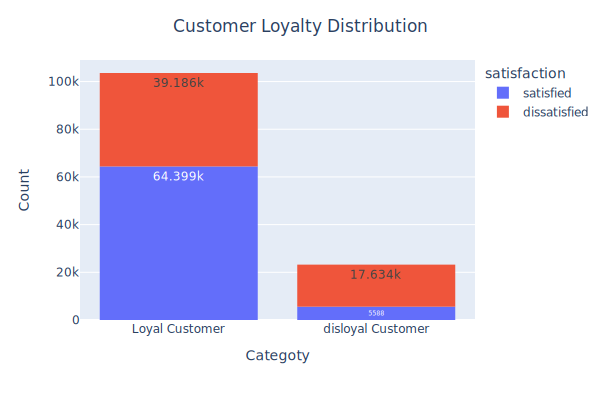

In [81]:
fig = px.histogram(df, x='Customer Type', color='satisfaction', text_auto=True)
fig.update_layout(title='Customer Loyalty Distribution',
                  title_x=0.5, title_y=0.95,
                  width=600, height=400,
                  yaxis_title='Count',
                  xaxis_title='Categoty')
fig.show()

Loyal customers showed significantly more satisfaction, compared to air passengers or the overall precentage.

In [82]:
satisfied = df[df.satisfaction.isin(['satisfied'])]
dissatisfied = df[df.satisfaction.isin(['dissatisfied'])]
len(dissatisfied)

56820

In [83]:
# helper function to generate ratio satisfaction DataFrame
def get_satisfaction_rate_dataframe(mydf, category):
    df_all = mydf.groupby(category).agg('count')['satisfaction']
    df_category_satisfied = df[df.satisfaction.isin(['satisfied'])].groupby(category).agg('count')['satisfaction']
    df_category_dissatisfied = df[df.satisfaction.isin(['dissatisfied'])].groupby(category).agg('count')['satisfaction']
    category_satisfied_ratio = df_category_satisfied / df_all
    category_dissatisfied_ratio = 1 - category_satisfied_ratio
    categoty_satisfaction_frame = {'satisfied': category_satisfied_ratio,
         'dissatisfied': category_dissatisfied_ratio}
    cat_frame = pd.DataFrame(categoty_satisfaction_frame)
    return cat_frame

# calculates the satisfaction rate given a dataframe
def get_satisfaction_rate(df):
    return len(df[df.satisfaction.isin(['satisfied'])]) / len(df)

In [84]:
# lets test the `get_satisfaction_rate` function
base_satisfaction = round(get_satisfaction_rate(df), 3)
print(f'base satisfaction rate is: {base_satisfaction}')

base satisfaction rate is: 0.552


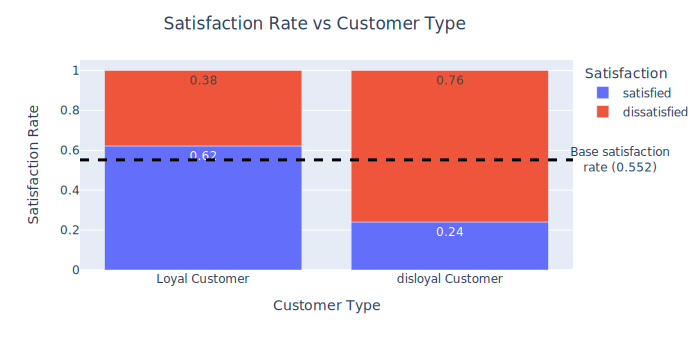

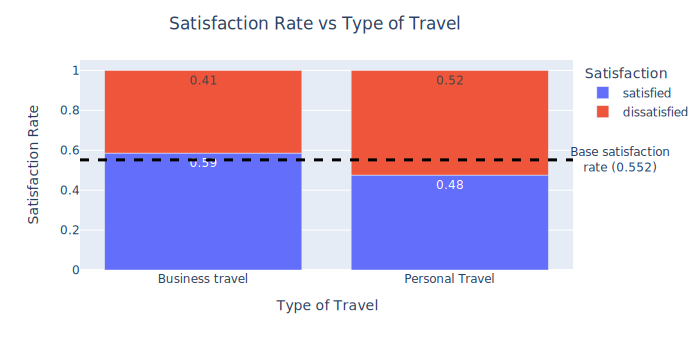

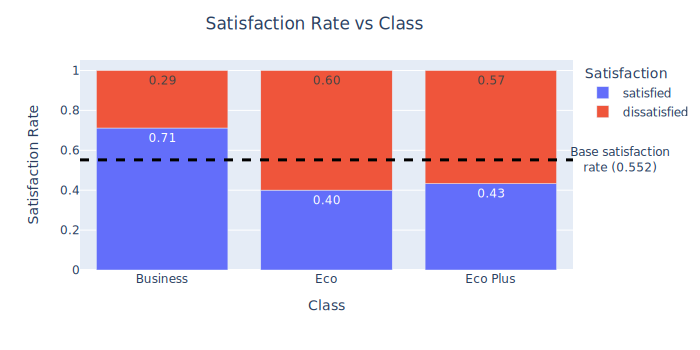

In [85]:
columns = ['Customer Type', 'Type of Travel', 'Class']
for column in columns:
  df_satisfied= get_satisfaction_rate_dataframe(df, column)

  fig = px.bar(df_satisfied, x=df_satisfied.index, text_auto='.2f', y=['satisfied',  'dissatisfied'], labels={'variable': 'Satisfaction'}).update_xaxes(type='category')
  fig.add_hline(y=base_satisfaction, line_width=3, line_dash="dash", line_color="black",  annotation_text=f"Base satisfaction<br>rate ({base_satisfaction})",
                              annotation_position="right")
  fig.update_layout(title=f'Satisfaction Rate vs {column}', title_x = 0.45, title_y = 0.95,
                width=700, height=350,
                yaxis_title = 'Satisfaction Rate',

                xaxis={'categoryorder':'sum ascending'},
                xaxis_title = column)
  fig.show()

Air Passengers that flew business class, showed higher satisfaction rates

## Features Engineering

In [86]:
df.head()

satisfaction   Customer Type  Age   Type of Travel Class  Flight Distance  \
0    satisfied  Loyal Customer   65  Personal Travel   Eco              265   
1    satisfied  Loyal Customer   15  Personal Travel   Eco             2138   
2    satisfied  Loyal Customer   60  Personal Travel   Eco              623   
3    satisfied  Loyal Customer   70  Personal Travel   Eco              354   
4    satisfied  Loyal Customer   30  Personal Travel   Eco             1894   

   Seat comfort  Departure/Arrival time convenient  Food and drink  \
0             0                                  0               0   
1             0                                  0               0   
2             0                                  0               0   
3             0                                  0               0   
4             0                                  0               0   

   Gate location  ...  Online support  Ease of Online booking  \
0              2  ...               2                       3   
1              3  ...               2                       2   
2              3  ...               3                       1   
3              3  ...               4                       2   
4              3  ...               2                       2   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0                 3                 0                 3                5   
1                 3                 3                 4                4   
2                 1                 0                 1                4   
3                 2                 0                 2                4   
4                 5                 4                 5                5   

   Cleanliness  Online boarding  Departure Delay in Minutes  \
0            3                2                           0   
1            4                2                           0   
2            1                3                           0   
3            2                5                           0   
4            4                2                           0   

   Arrival Delay in Minutes  
0                       0.0  
1                       0.0  
2                       0.0  
3                       0.0  
4                       0.0  

[5 rows x 22 columns]

In [87]:
# Initialize OneHotEncoder
encoder = OneHotEncoder(drop='if_binary', sparse_output=False)
cat_columns = ['Customer Type', 'Class', 'Type of Travel']
# Fit and transform categorical columns
encoded_cat_cols = encoder.fit_transform(df[cat_columns])

# Convert to DataFrame
encoded_df = pd.DataFrame(encoded_cat_cols, columns=encoder.get_feature_names_out(cat_columns))

# Concatenate with numerical columns
num_cols = df.select_dtypes(include='number').columns.tolist()
encoded_df = pd.concat([encoded_df, df[num_cols]], axis=1)
encoded_df.head()

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform numerical columns
scaled_num_cols = scaler.fit_transform(encoded_df[num_cols])
encoded_df[num_cols] = scaled_num_cols

encoded_df['satisfaction'] = df['satisfaction'].map({'satisfied': 0, 'dissatisfied': 1})
df = encoded_df
df.head()

Customer Type_disloyal Customer  Class_Business  Class_Eco  Class_Eco Plus  \
0                              0.0             0.0        1.0             0.0   
1                              0.0             0.0        1.0             0.0   
2                              0.0             0.0        1.0             0.0   
3                              0.0             0.0        1.0             0.0   
4                              0.0             0.0        1.0             0.0   

   Type of Travel_Personal Travel       Age  Flight Distance  Seat comfort  \
0                             1.0  1.691054        -1.665910      -2.03661   
1                             1.0 -1.616556         0.177471      -2.03661   
2                             1.0  1.360293        -1.313571      -2.03661   
3                             1.0  2.021815        -1.578318      -2.03661   
4                             1.0 -0.624273        -0.062670      -2.03661   

   Departure/Arrival time convenient  Food and drink  ...  \
0                          -1.955844       -1.975458  ...   
1                          -1.955844       -1.975458  ...   
2                          -1.955844       -1.975458  ...   
3                          -1.955844       -1.975458  ...   
4                          -1.955844       -1.975458  ...   

   Ease of Online booking  On-board service  Leg room service  \
0               -0.366657         -0.371299         -2.687109   
1               -1.132795         -0.371299         -0.372339   
2               -1.898932         -1.947283         -2.687109   
3               -1.132795         -1.159291         -2.687109   
4               -1.132795          1.204685          0.399252   

   Baggage handling  Checkin service  Cleanliness  Online boarding  \
0         -0.600260         1.316636    -0.626412        -1.044283   
1          0.263069         0.522068     0.246205        -1.044283   
2         -2.326918         0.522068    -2.371646        -0.273610   
3         -1.463589         0.522068    -1.499029         1.267735   
4          1.126398         1.316636     0.246205        -1.044283   

   Departure Delay in Minutes  Arrival Delay in Minutes  satisfaction  
0                   -0.492323                 -0.503032             0  
1                   -0.492323                 -0.503032             0  
2                   -0.492323                 -0.503032             0  
3                   -0.492323                 -0.503032             0  
4                   -0.492323                 -0.503032             0  

[5 rows x 24 columns]

## Split Data Train/Test

In [88]:
X = df.drop(['satisfaction'], axis=1)
y = df['satisfaction']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [89]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [90]:
results = {}
# Create anf fit dummy classifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train)

# Predict the labels for the train and test data
y_pred_train = dummy_clf.predict(x_train)
y_pred_test = dummy_clf.predict(x_test)

# Calculate the accuracy score for the train data
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Accuracy score for the train data:", accuracy_train)

# Calculate the accuracy score for the test data
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy score for the test data:", accuracy_test)

Accuracy score for the train data: 0.552021449976342
Accuracy score for the test data: 0.5516055769352092


## Modeling

###  EDA - Comparing different classification models
We'll run an initial model comparison on a list of classifiers

> Add blockquote



Analyzing model:  Logistic Regression
Confusion Matrix for Logistic Regression: 

              precision    recall  f1-score   support

           0       0.85      0.85      0.85     17487
           1       0.81      0.81      0.81     14215

    accuracy                           0.83     31702
   macro avg       0.83      0.83      0.83     31702
weighted avg       0.83      0.83      0.83     31702

Analyzing model:  SVM
Confusion Matrix for SVM: 

              precision    recall  f1-score   support

           0       0.95      0.94      0.94     17487
           1       0.93      0.94      0.93     14215

    accuracy                           0.94     31702
   macro avg       0.94      0.94      0.94     31702
weighted avg       0.94      0.94      0.94     31702

Analyzing model:  KNN
Confusion Matrix for KNN: 

              precision    recall  f1-score   support

           0       0.94      0.91      0.93     17487
           1       0.89      0.93      0.91     14215



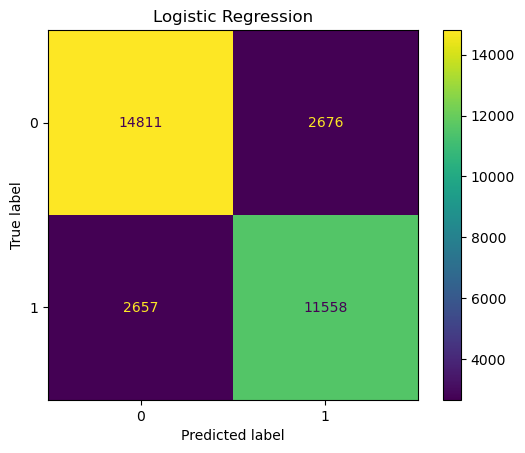

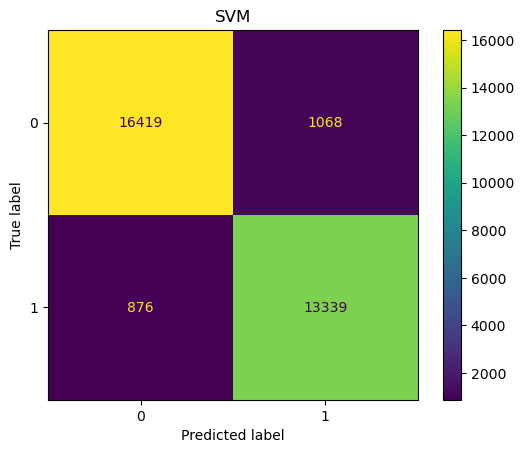

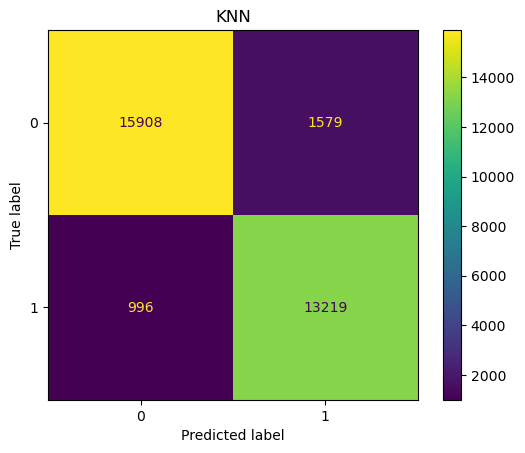

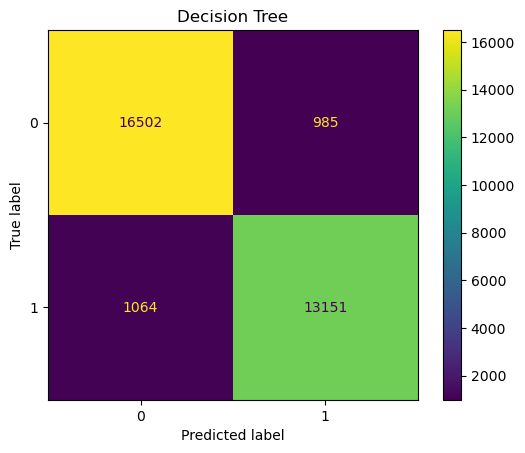

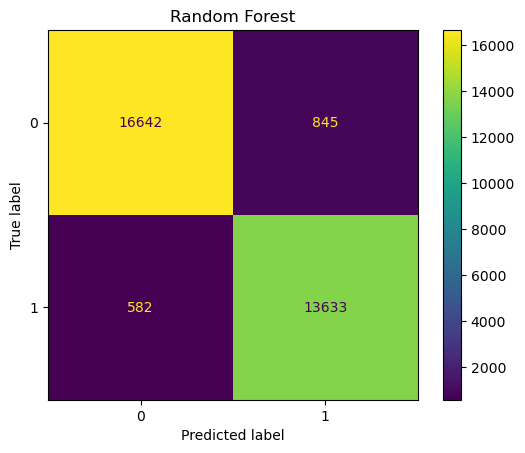

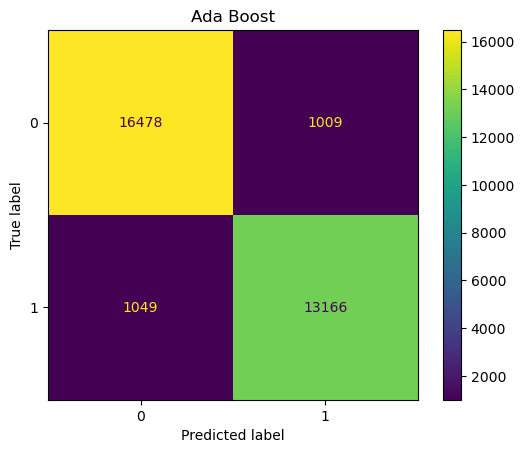

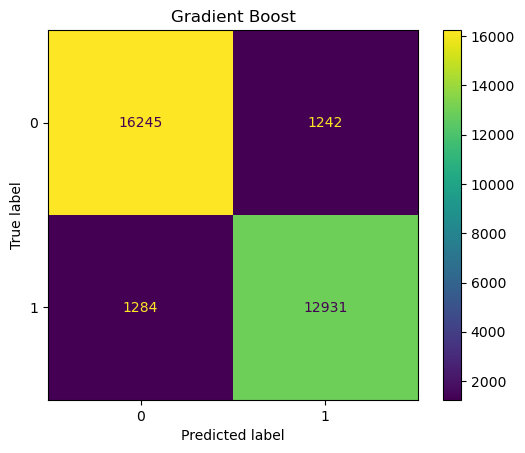

In [91]:
# Create a dictionary to store the results
results = {}

# List of models to test on the scaled data
models = [
    {
        'model': LogisticRegression(max_iter=5000),
        'key': 'Logistic Regression'
    },
    {
        'model': SVC(),
        'key': 'SVM'
    },
    {
        'model': KNeighborsClassifier(),
        'key': 'KNN'
    },
    {
        'model': DecisionTreeClassifier(),
        'key': 'Decision Tree'
    },
    {
        'model': RandomForestClassifier(oob_score=True),
        'key': 'Random Forest'
    },
    {
        'model': AdaBoostClassifier(estimator=DecisionTreeClassifier(), algorithm='SAMME'),
        'key': 'Ada Boost'
    },
    {
        'model': GradientBoostingClassifier(),
        'key': 'Gradient Boost'
    },
]


for i, model in enumerate(models):
    key = model['key']
    print('Analyzing model: ', model['key'])
    mdl = model['model']
    start_t = time.time()
    mdl.fit(x_train.values, y_train)
    models[i]['fitted_pipe']= mdl

    end_t = time.time()
    y_pred_train = mdl.predict(x_train.values)
    y_pred_test = mdl.predict(x_test.values)
    print(f'Confusion Matrix for {key}: \n')
    cm = confusion_matrix(y_test, y_pred_test, labels=mdl.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mdl.classes_)
    disp.plot()
    disp.ax_.set_title(model['key'])


    results[key] = {
        'score': mdl.score(x_test.values, y_test),
        'train_time': end_t - start_t,
        'train_accuracy': accuracy_score(y_train, y_pred_train),
        'test_accuracy': accuracy_score(y_test, y_pred_test),
        'train_f1': f1_score(y_train, y_pred_train, average='weighted', labels=np.unique(y_pred_train)),
        'test_f1': f1_score(y_test, y_pred_test, average='weighted', labels=np.unique(y_pred_test))
    }
    print(classification_report(y_test, y_pred_test, labels=np.unique(y_pred_test)))


                        score  train_time  train_accuracy  test_accuracy  \
Model                                                                      
Logistic Regression  0.831777    0.092025        0.829599       0.831777   
SVM                  0.938679   15.819615        0.946322       0.938679   
KNN                  0.918775    0.019300        0.944156       0.918775   
Decision Tree        0.935367    0.604853        1.000000       0.935367   
Random Forest        0.954987    3.700209        1.000000       0.954987   
Ada Boost            0.935083    0.809719        1.000000       0.935083   
Gradient Boost       0.920320   13.494803        0.921371       0.920320   

                     train_f1   test_f1  
Model                                    
Logistic Regression  0.829586  0.831788  
SVM                  0.946358  0.938715  
KNN                  0.944233  0.918902  
Decision Tree        1.000000  0.935350  
Random Forest        1.000000  0.955023  
Ada Boost            

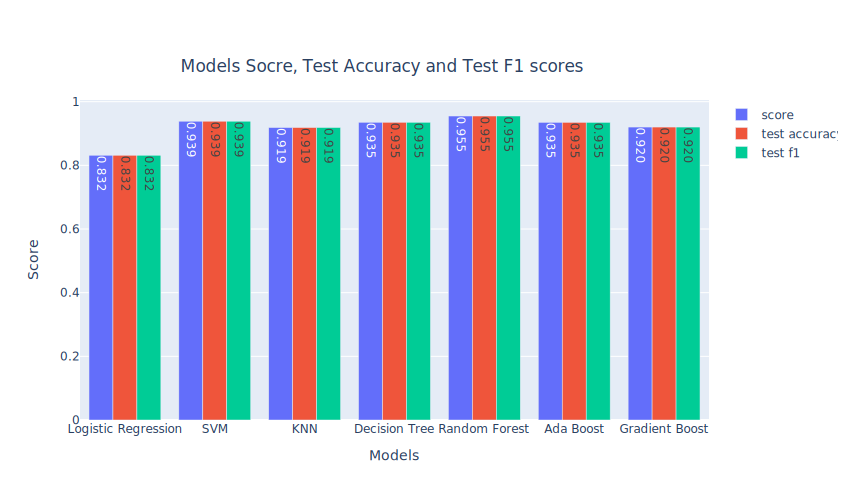

[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   6.9s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=  15.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=300; total time=  28.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=  10.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   8.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=  14.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=4, n_estimators=300; total time=  22.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=4, n_estimators=300; total time=  30.7s
[CV] END max_depth=None, max_features=log2, min_samples_split=2, n_estimators=200; total time=  14.2s
[CV] END max_depth=None, max_features=log2, min_samples_split=2, n_estimators=300;

In [100]:
import plotly.graph_objects as go

# Create a DataFrame to display results
df_results = pd.DataFrame(results).transpose()
df_results.index.name = 'Model'
print(df_results)

# Display the display results with Plotly
fig = go.Figure(data=[
    go.Bar(name='score', x=df_results.index, y=df_results.score, text=df_results.score),
    go.Bar(name='test accuracy', x=df_results.index, y=df_results.test_accuracy, text=df_results.test_accuracy),
    go.Bar(name='test f1', x=df_results.index, y=df_results.test_f1, text=df_results.test_f1)])
fig.update_layout(title="Models Socre, Test Accuracy and Test F1 scores", title_x=0.45, title_y=0.88,
                  yaxis_title='Score', xaxis_title='Models', height=500, width=850)
fig.update_traces(texttemplate='%{y:.3f}')
fig.show()

Best classifier with the highest test classification accuracy is `RandomForestClassifier` with accuracy of `95.54%`. Right after in second place came `SVM` with `94.03%` test accuracy  

#### RandomForest OOB score (using the whole data set)

In [93]:
# Trying to use the whole dataset and use out-of-bag samples to estimate the generalization score
rf = RandomForestClassifier(oob_score=True)
rf.fit(X, y)
print(rf.oob_score_)

0.9548132200903736


When training RandomForestClassifier with the whole data set and using the out-of-bag samples to estimate the generalization score,  accuracy is `95.55%`, which is very similar to the one we recieved when training the model on the split train/test sets, which produced `95.54%` test accuracy. 

In [94]:
# check the params that were used to fit the models and we'll run GridSearchCV to fine tune these
for model_x in models:
    print(f'Analyzing params for {model_x['key']}\n:{model_x['fitted_pipe'].get_params()}')

Analyzing params for Logistic Regression
:{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 5000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Analyzing params for SVM
:{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'n_jobs': None, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Analyzing params for KNN
:{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Analyzing params for Decision Tree
:{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrea

#### GridSearchCV with leading models
We'll pick the best proforming models from EDA and run GridSearchCV in hope to improve out test accuracy score

In [95]:
Grid_CV_results  = {}

# Define the hyperparameters grid
grid_search_mdl = [{
      'key': 'RandomForestClassifier',
      'model' : RandomForestClassifier(),
      'param_grid': {
        'n_estimators': [100, 200, 300],      # Number of trees in the forest
        'max_depth': [None, 20],         # Maximum depth of the tree
        'max_features': ["sqrt", "log2"],   # The number of features to consider when looking for the best split
        'min_samples_split': [2, 4]
        }
    },
    {
      'key': 'AdaBoostClassifier',
      'model' : AdaBoostClassifier(),
      'param_grid' : {
        'n_estimators': [100, 200, 300],  # Number of trees in the forest
        'learning_rate': [0.7, 1.0, 1.3],  # Learning rate
      }
    },
    {
      'key': 'DecisionTreeClassifier',
      'model' : DecisionTreeClassifier(),
      'param_grid' : {
        'criterion': ['gini', 'entropy'],  # The function to measure the quality of a split
        'splitter': ['best', 'random'],  # The strategy used to choose the split at each node
        'max_depth': [None, 25],      # Maximum depth of the tree
      }
    },
    {
      'key': 'SVM',
      'model': SVC(),
      'param_grid' : {
        'kernel': ['linear', 'rbf'],  # Kernel type
        'gamma': ['scale', 'auto']  # Kernel coefficient
      }
    }
]

for mdl in grid_search_mdl:
  print(f'Analyzing model: {mdl["key"]}')

  # Create GridSearchCV
  grid_search = GridSearchCV(estimator=mdl['model'], param_grid=mdl['param_grid'], cv=5, n_jobs=-1, verbose=2)

  start_time = time.time()

  # Fit the grid search to the data
  grid_search.fit(x_train.values, y_train)

  train_time = time.time() - start_time

  print("Best parameters found:", grid_search.best_params_)

  # Print the best score found
  print("Best score found:", grid_search.best_score_)

  best_model = grid_search.best_estimator_

  # Make predictions on test data
  y_pred_test = best_model.predict(x_test.values)

  # Evaluate accuracy
  test_accuracy = accuracy_score(y_test, y_pred_test)
  print("Accuracy on test data:", test_accuracy)

  # Print the best parameters found
  Grid_CV_results[mdl['key']] = {
      'train_time': train_time,
      'best_params': grid_search.best_params_,
      'best_score': grid_search.best_score_,
      'test_accuracy': test_accuracy
  }
  print(classification_report(y_test, y_pred_test, labels=np.unique(y_pred_test)))

Analyzing model: RandomForestClassifier
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300}
Best score found: 0.9544818884390937
Accuracy on test data: 0.9551763295691124
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     17487
           1       0.94      0.96      0.95     14215

    accuracy                           0.96     31702
   macro avg       0.95      0.96      0.95     31702
weighted avg       0.96      0.96      0.96     31702

Analyzing model: AdaBoostClassifier
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/ben/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ben/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ben/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ben/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorit

Best parameters found: {'learning_rate': 1.0, 'n_estimators': 200}
Best score found: 0.9025287839756059
Accuracy on test data: 0.9020881963283074
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     17487
           1       0.89      0.89      0.89     14215

    accuracy                           0.90     31702
   macro avg       0.90      0.90      0.90     31702
weighted avg       0.90      0.90      0.90     31702

Analyzing model: DecisionTreeClassifier
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found: {'criterion': 'entropy', 'max_depth': 25, 'splitter': 'random'}
Best score found: 0.9380158771883709
Accuracy on test data: 0.9337581225159296
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     17487
           1       0.92      0.93      0.93     14215

    accuracy                           0.93     31702
   macro avg       0.93      0.93      0.93

                         train_time  \
Model                                 
RandomForestClassifier   504.590399   
AdaBoostClassifier       288.239139   
DecisionTreeClassifier     8.557695   
SVM                     1496.657475   

                                                              best_params  \
Model                                                                       
RandomForestClassifier  {'max_depth': None, 'max_features': 'sqrt', 'm...   
AdaBoostClassifier            {'learning_rate': 1.0, 'n_estimators': 200}   
DecisionTreeClassifier  {'criterion': 'entropy', 'max_depth': 25, 'spl...   
SVM                                   {'gamma': 'scale', 'kernel': 'rbf'}   

                       best_score test_accuracy  
Model                                            
RandomForestClassifier   0.954482      0.955176  
AdaBoostClassifier       0.902529      0.902088  
DecisionTreeClassifier   0.938016      0.933758  
SVM                      0.938016      0.938679  


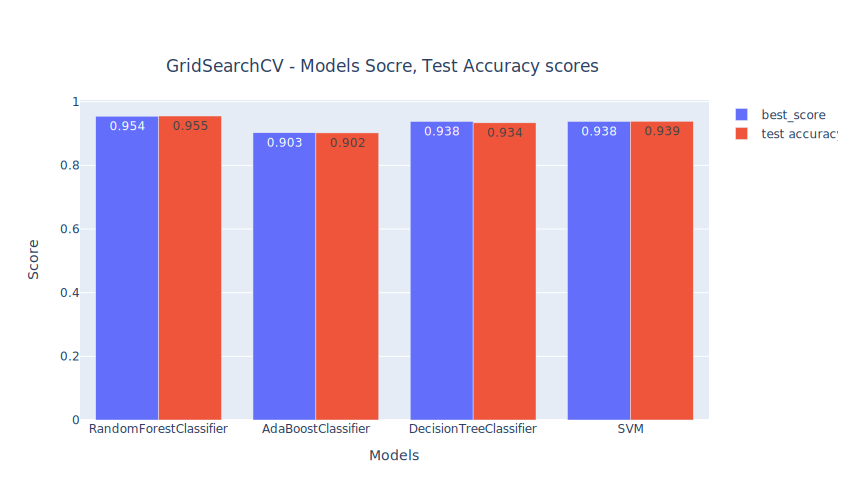

In [101]:
# Create a DataFrame to display Grid_CV_results
df_results = pd.DataFrame(Grid_CV_results).transpose()
df_results.index.name = 'Model'
print(df_results)

# Display the display results with Plotly
fig = go.Figure(data=[
    go.Bar(name='best_score', x=df_results.index, y=df_results.best_score, text=df_results.best_score),
    go.Bar(name='test accuracy', x=df_results.index, y=df_results.test_accuracy, text=df_results.test_accuracy)
])
fig.update_layout(title="GridSearchCV - Models Socre, Test Accuracy scores", title_x=0.45, title_y=0.88,
                  yaxis_title='Score', xaxis_title='Models', height=500, width=850)
fig.update_traces(texttemplate='%{y:.3f}')
fig.show()

Running GridSearchCV didn't improve much the results that we reieved from the initial model training. 
`RandomForestClassifier` test didn't improve and produced `95.5%` accuracy.`DecisionTreeClassifier`'s test accuracy improved from `93.5%` to `93.86%`, but it wasn't enough to make it the best model.

#### Feature Importance for Random Forest Model

First we'll use the feature importance from the leading model, RandemForest classifier:

Top 10 most important features:


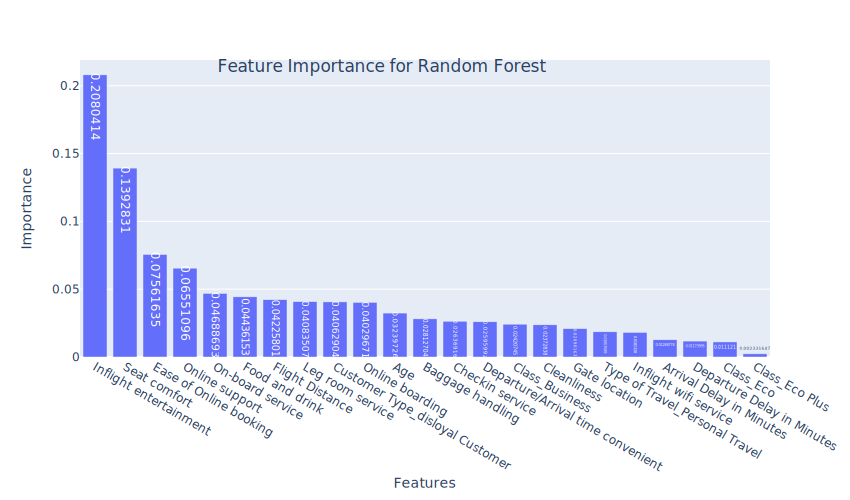

In [102]:
# We'll analyze feature importance of random forest
random_f = models[4]['fitted_pipe']
feature_importance = list(zip(list(x_train.columns), random_f.feature_importances_))
# Sort features by their importance (absolute coefficient value)
feature_importance.sort(key=lambda x: x[1], reverse=True)

feature_importances = {'feature': [], 'importance': []}
# Display the top 10 most important features
print(f"Top 10 most important features:")
for feature, importance in feature_importance:
    feature_importances['feature'].append(feature)
    feature_importances['importance'].append(importance)

df1 = pd.DataFrame(feature_importances)
fig = px.bar(df1, x='feature', y='importance', text_auto=True)
fig.update_layout(title=f'Feature Importance for Random Forest', title_x=0.45, title_y=0.88,
                yaxis_title='Importance', xaxis_title='Features', height=500, width=850)
fig.show()



We'll also calculate permutation importance from the fitted RandomForest model:

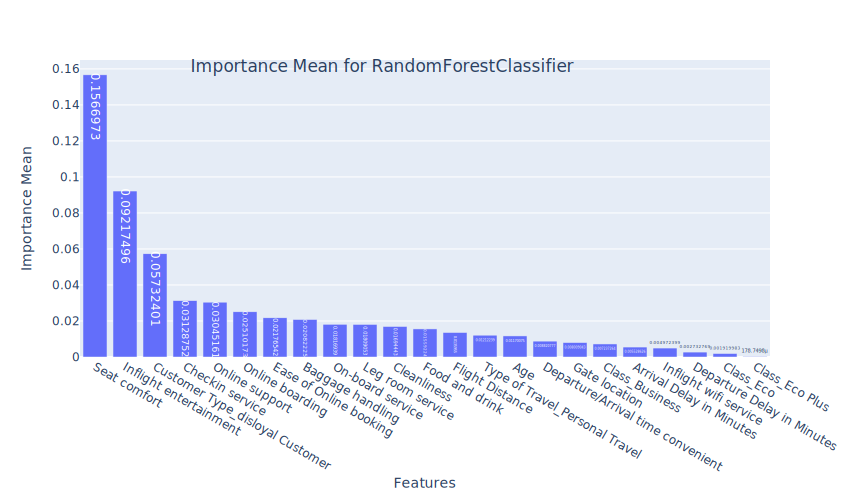

In [103]:
# define a generic function for calculating permutation importance
permutation_importance_results = {'feature': [], 'importance_mean': [], 'importance_std': [], 'model':[]}
def calc_permutation_importance(model, X, y, model_name, n_repeats=10, random_state=0):
  r = permutation_importance(model, X, y, n_repeats=10, random_state=0)
  for i in r.importances_mean.argsort()[::-1]:
      permutation_importance_results['feature'].append(X.columns.tolist()[i])
      permutation_importance_results['importance_mean'].append(r.importances_mean[i])
      permutation_importance_results['importance_std'].append(r.importances_std[i])
      permutation_importance_results['model'].append(model_name)

  df2 = pd.DataFrame(permutation_importance_results)
  df2[df2['model'] == model_name].head(20)
  fig = px.bar(df2[df2['model'] == model_name], x='feature', y='importance_mean', text_auto=True)
  fig.update_layout(title=f'Importance Mean for {model_name}', title_x=0.45, title_y=0.88,
                  yaxis_title='Importance Mean', xaxis_title='Features', height=500, width=850)
  fig.show()

calc_permutation_importance(random_f, x_train, y_train, 'RandomForestClassifier')

We can see that `Seat Comfort` and `Inflight Entrtainment` were the leading important features in both methods of analyzing the importance of the features.
We can also see that `Personal Travel` type and Disloyal Customer type had some importance (in a negative context). `Ease of Online Booking` also played part in customer satisfaction. Surprisingly, cleaningless didn't play a major part of the statisfaction.

#### Neural Networks - a Simple Network




In [ ]:
!pip install scikeras > /dev/null
from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.regularizers import L1, L2
from scikeras.wrappers import KerasClassifier

In [ ]:
model = Sequential([
 Dense(256, activation='relu', input_shape=(x_train.shape[1],)),
 Dense(1, activation='sigmoid')
])
model.compile(optimizer='Adam',loss='bce', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy',mode='max', patience=10)
history_1 = model.fit(x_train, y_train,
                      epochs=100,
                      callbacks=[early_stopping],
                      validation_split=0.2)

Epoch 1/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8737 - loss: 0.2927 - val_accuracy: 0.9210 - val_loss: 0.1888
Epoch 2/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9236 - loss: 0.1823 - val_accuracy: 0.9303 - val_loss: 0.1662
Epoch 3/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9344 - loss: 0.1593 - val_accuracy: 0.9374 - val_loss: 0.1499
Epoch 4/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9395 - loss: 0.1453 - val_accuracy: 0.9404 - val_loss: 0.1394
Epoch 5/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9434 - loss: 0.1343 - val_accuracy: 0.9409 - val_loss: 0.1345
Epoch 6/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9454 - loss: 0.1264 - val_accuracy: 0.9419 - val_loss: 0.1293
Epoch 7/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9493 - loss: 0.1191 - val_accuracy: 0.9434 - val_loss: 0.1265
Epoch 8/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9500 - loss: 0

In [ ]:
history_1.model.summary()
model.evaluate(x_test, y_test)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,205 (75.02 KB)

 Trainable params: 6,401 (25.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,804 (50.02 KB)

595/595 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9455 - loss: 0.1326


[0.12552522122859955, 0.9493744373321533]

In [ ]:
accuracies = history_1.history['accuracy']
validation_accuracies = history_1.history['val_accuracy']

fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(0, 46)), y=accuracies, mode='lines', name='Accuracy'))
fig.add_trace(go.Scatter(x=list(range(0, 46)), y=validation_accuracies, mode='lines', name='Validation Accuracy'))

fig.update_layout(title="Accuracy vs Validation Accuracy over Epochs", title_x=0.45, title_y=0.9,
                  yaxis_title='Accuracy', xaxis_title='Epoch', height=500, width=900)

fig.show()

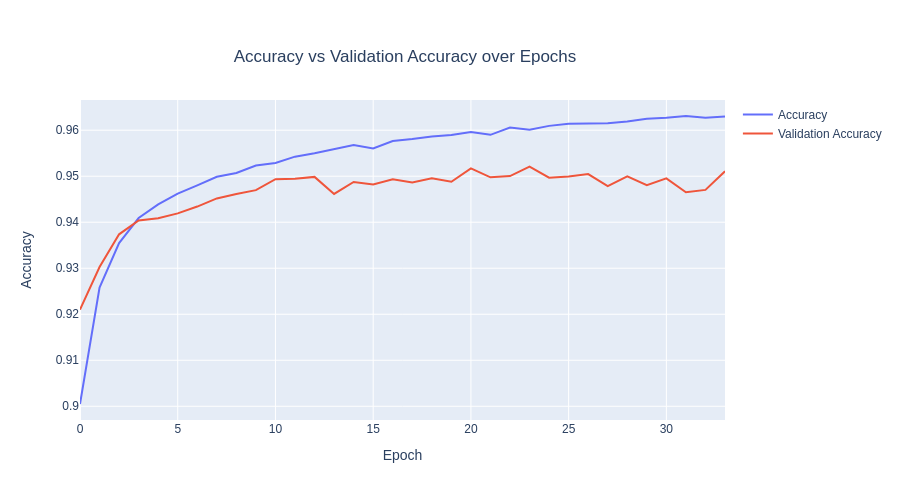

In [106]:
from IPython.display import Image
Image(filename='img/nn_1.png')

We can see that using a basic neural networks shows model performance of `95.17%` accuracy, with peak of `95.2%` during model training (arouns epoc 20).

#### Neural Networks - more complex - with dropout regularization and more layers


In [ ]:
model_2 = Sequential([
 Dense(512, activation='relu', input_shape=(x_train.shape[1],)),
 Dropout(0.25),
 Dense(256, activation='relu'),
 Dropout(0.25),
 Dense(128, activation='relu'),
 Dense(1, activation='sigmoid')
])
model_2.compile(optimizer='Adam',loss='bce', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy',mode='max', patience=20)
history_2 = model_2.fit(x_train, y_train,
                      epochs=100,
                      callbacks=[early_stopping],
                      validation_split=0.2)

Epoch 1/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8856 - loss: 0.2626 - val_accuracy: 0.9371 - val_loss: 0.1487
Epoch 2/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9321 - loss: 0.1558 - val_accuracy: 0.9457 - val_loss: 0.1261
Epoch 3/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9435 - loss: 0.1304 - val_accuracy: 0.9434 - val_loss: 0.1319
Epoch 4/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9482 - loss: 0.1225 - val_accuracy: 0.9517 - val_loss: 0.1120
Epoch 5/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9504 - loss: 0.1130 - val_accuracy: 0.9525 - val_loss: 0.1059
Epoch 6/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9537 - loss: 0.1066 - val_accuracy: 0.9540 - val_loss: 0.1056
Epoch 7/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9540 - loss: 0.1031 - val_accuracy: 0.9544 - val_loss: 0.1022
Epoch 8/100
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9547 - loss: 

In [ ]:
history_2.model.summary()
model.evaluate(x_test, y_test)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 512)                 │          12,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 529,925 (2.02 MB)

 Trainable params: 176,641 (690.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 353,284 (1.35 MB)

595/595 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9455 - loss: 0.1326


[0.12552522122859955, 0.9493744373321533]

Using the more complex neural network with regularization (via drpouts), we improved the model accuracy to `95.76%`

In [ ]:
accuracies = history_2.history['accuracy']
validation_accuracies = history_2.history['val_accuracy']

fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(0, 46)), y=accuracies, mode='lines', name='Accuracy'))
fig.add_trace(go.Scatter(x=list(range(0, 46)), y=validation_accuracies, mode='lines', name='Validation Accuracy'))

fig.update_layout(title="Accuracy vs Validation Accuracy over Epochs", title_x=0.45, title_y=0.9,
                  yaxis_title='Accuracy', xaxis_title='Epoch', height=500, width=900)

fig.show()


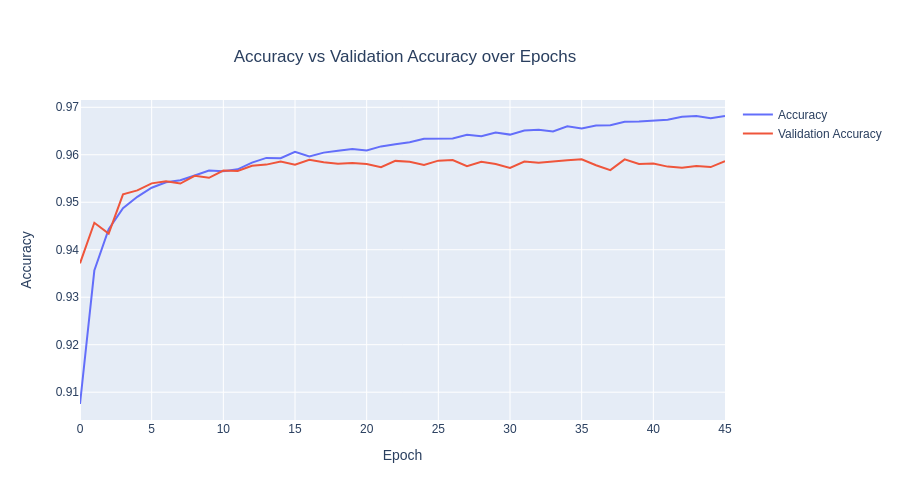

In [107]:
from IPython.display import Image

Image(filename='img/nn_2.png')

We can see that this model validation accuracy peaked at epoc 17 with `95.9%` accuracy and didn't improve much. We can see as the epoc number grows how the model slowly starts to overfit.

#### Neural Networks with KerasClassifier and GridSearchCV

In [ ]:
def build_function(neurons_1 = 1, neurons_2 = 1, neurons_3 = 1, dropout=0.3, loss_func="bce", optimizer=['rmsprop']):
    model = Sequential()
    model.add(Dense(units=neurons_1, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(Dropout(rate=0.3))
    model.add(Dense(units=neurons_2, activation='relu'))
    model.add(Dropout(rate=0.3))
    model.add(Dense(units=neurons_3, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss = loss_func, metrics = ['accuracy'])
    return model

In [ ]:
model_grid = KerasClassifier(build_fn=build_function,
                        epochs = 50,
                        callbacks=[EarlyStopping(monitor='accuracy',mode='max', patience=10)],
                        batch_size=256,
                        verbose = 1)

params = {'model__neurons_1': [256, 512],
          'model__neurons_2': [128],
          'model__neurons_3': [128, 64],
          'model__loss_func': ['binary_crossentropy', 'binary_focal_crossentropy'],
          'model__optimizer': ['Adam', 'rmsprop']}

grid_cv = GridSearchCV(model_grid, param_grid=params)
print(model_grid.get_params().keys())
grid_cv_fit = grid_cv.fit(x_train, y_train)
grid_score = grid_cv_fit.score(x_test, y_test)
grid_score

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'class_weight'])
Epoch 1/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8399 - loss: 0.3591
Epoch 2/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9025 - loss: 0.2269
Epoch 3/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9167 - loss: 0.1948
Epoch 4/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9265 - loss: 0.1766
Epoch 5/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9318 - loss: 0.1598
Epoch 6/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9351 - loss: 0.1514
Epoch 7/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9381 - loss: 0.1413
Epoch 8/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9426 - loss: 0.1347
Epoch 9/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9445 - loss: 0.

0.9574474796542805

In [ ]:
print(grid_cv_fit.best_params_)
print(grid_cv_fit.best_score_)
print(grid_cv_fit.best_estimator_)

{'model__loss_func': 'binary_crossentropy', 'model__neurons_1': 512, 'model__neurons_2': 128, 'model__neurons_3': 128}
0.9580779138846539
KerasClassifier(
	model=None
	build_fn=<function build_function at 0x7ae7b45de320>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=256
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x7ae671e5dff0>]
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
	class_weight=None
	model__loss_func=binary_crossentropy
	model__neurons_1=512
	model__neurons_2=128
	model__neurons_3=128
)


We can see that GridSearch improved the model accuracy from `95.76%` for the complex NN model to `95.84%`, which is very similar to the accuracy peak during the NN complex model training

Best grid params were:

loss_func: binary_crossentropy<br>
First layer neurons count:  512<br>
Second layer neurons count: 128<br>
Third layer neurons count:  128<br>

